# Graded Assignment 3.1_ ANN for Medical Diagnosis

In [ ]:
# Core
import numpy as np
import pandas as pd
from collections import Counter


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("TensorFlow:", tf.__version__)


NumPy: 2.0.2
Pandas: 2.2.2
TensorFlow: 2.19.0


In [ ]:

df = pd.read_csv("/content/sample_data/enhanced_diabetes_dataset.csv")

print("Shape:", df.shape)
df.head().T


Shape: (2000, 17)


,0,1,2,3,4
Age,52.000,43.000,55.000,68.000,41.000
Gender,1.000,1.000,1.000,1.000,0.000
Pregnancies,1.000,2.000,4.000,3.000,0.000
Glucose,124.000,144.000,141.000,125.000,177.000
BloodPressure,95.000,86.000,113.000,110.000,92.000
SkinThickness,20.000,23.000,18.000,32.000,14.000
Insulin,0.000,3.000,297.000,210.000,189.000
BMI,36.000,32.900,43.400,22.700,38.100
DiabetesPedigreeFunction,0.078,0.118,0.139,0.197,0.078
HbA1c,4.700,6.300,5.400,5.200,10.500


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2000.0,45.858500,14.155164,20.000,36.00000,46.000,55.00000,80.0
Gender,2000.0,0.614000,0.486952,0.000,0.00000,1.000,1.00000,1.0
Pregnancies,2000.0,1.557000,1.758208,0.000,0.00000,1.000,3.00000,10.0
Glucose,2000.0,127.156000,28.018051,70.000,107.00000,126.000,146.00000,222.0
BloodPressure,1902.0,89.005258,12.119690,60.000,81.00000,89.000,97.00000,130.0
SkinThickness,1914.0,22.551724,8.843040,5.000,16.00000,22.000,28.00000,50.0
Insulin,2000.0,110.316500,114.417333,0.000,0.00000,88.000,195.00000,548.0
BMI,2000.0,29.493850,6.038741,16.000,25.40000,29.550,33.60000,49.4
DiabetesPedigreeFunction,2000.0,0.304637,0.289355,0.078,0.08375,0.213,0.39125,2.5
HbA1c,2000.0,6.179000,1.705257,4.000,4.70000,6.000,7.40000,12.0


## 2. EDA plots

In [ ]:

TARGET_COL = "Diabetes"  # based on your dataframe screenshot

binary_cols = ["Gender", "Smoking", "Prediabetes"]  # treat as categorical (0/1)
numeric_cols = [c for c in df.columns if c not in binary_cols + [TARGET_COL]]

# quick sanity
print("Target:", TARGET_COL)
print("Binary cols:", binary_cols)
print("Numeric cols:", numeric_cols)
print("Class balance:\n", df[TARGET_COL].value_counts())


Target: Diabetes
Binary cols: ['Gender', 'Smoking', 'Prediabetes']
Numeric cols: ['Age', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'HbA1c', 'FastingBS', 'Triglycerides', 'HDL', 'PhysicalActivity']
Class balance:
 Diabetes
1    1608
0     392
Name: count, dtype: int64


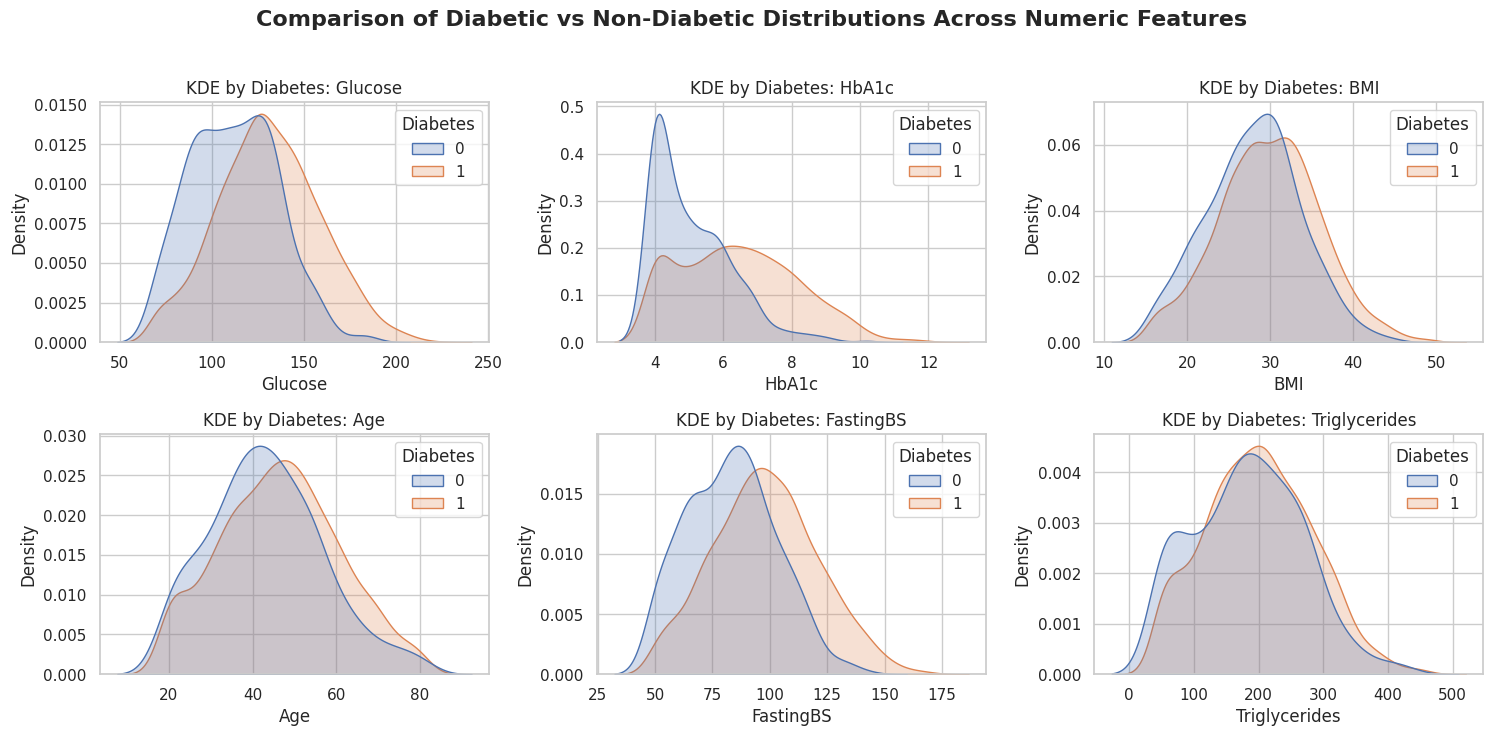

In [ ]:
def kde_grid_by_target(df, features, target=TARGET_COL, ncols=3):
    n = len(features)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.6*nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(features):
        ax = axes[i]
        sns.kdeplot(data=df, x=col, hue=target, fill=True, common_norm=False, ax=ax)
        ax.set_title(f"KDE by {target}: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Density")


    fig.suptitle(
        "Comparison of Diabetic vs Non-Diabetic Distributions Across Numeric Features",
        fontsize=16,
        fontweight="bold",
        y=1.02
    )
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# choose a good mix of numeric medical features
kde_features = ["Glucose", "HbA1c", "BMI", "Age", "FastingBS", "Triglycerides"]
kde_features = [c for c in kde_features if c in df.columns]

kde_grid_by_target(df, kde_features, target=TARGET_COL, ncols=3)


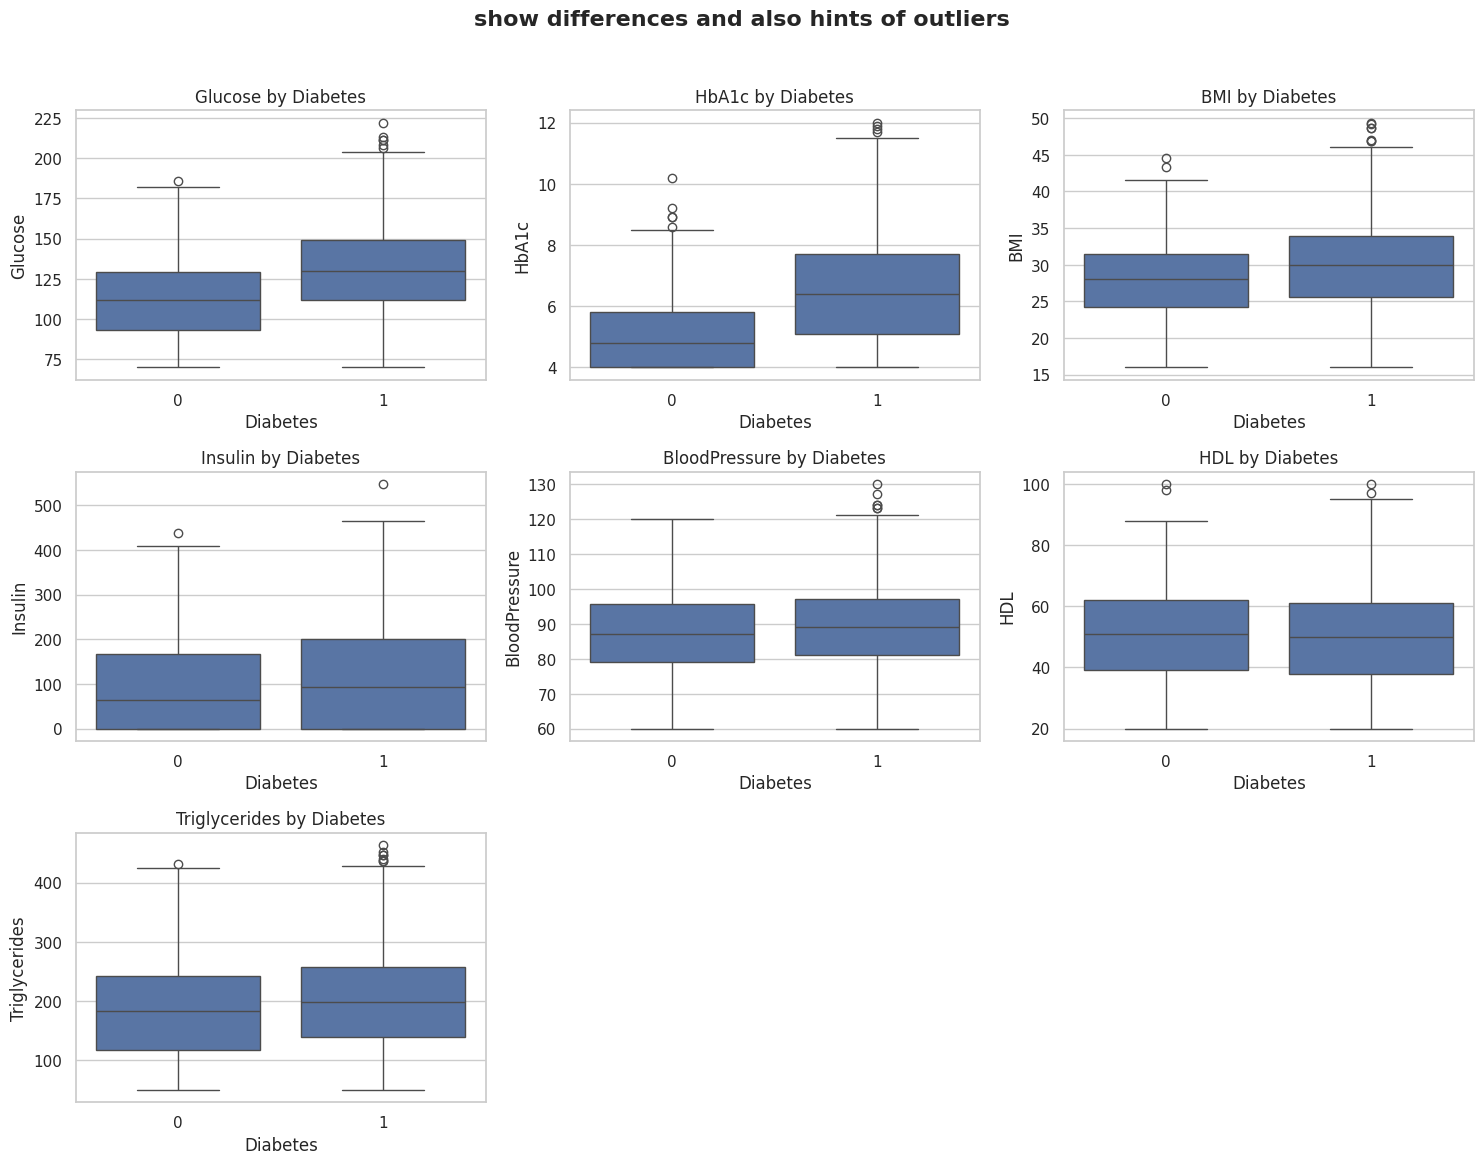

In [ ]:
def boxplot_grid_by_target(df, features, target=TARGET_COL, ncols=3):
    n = len(features)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(features):
        ax = axes[i]
        sns.boxplot(data=df, x=target, y=col, ax=ax)
        ax.set_title(f"{col} by {target}")
        ax.set_xlabel(target)
        ax.set_ylabel(col)

    fig.suptitle(
        "show differences and also hints of outliers",
        fontsize=16,
        fontweight="bold",
        y=1.02
    )
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

box_features = ["Glucose", "HbA1c", "BMI", "Insulin", "BloodPressure", "HDL", "Triglycerides"]
box_features = [c for c in box_features if c in df.columns]

boxplot_grid_by_target(df, box_features, target=TARGET_COL, ncols=3)


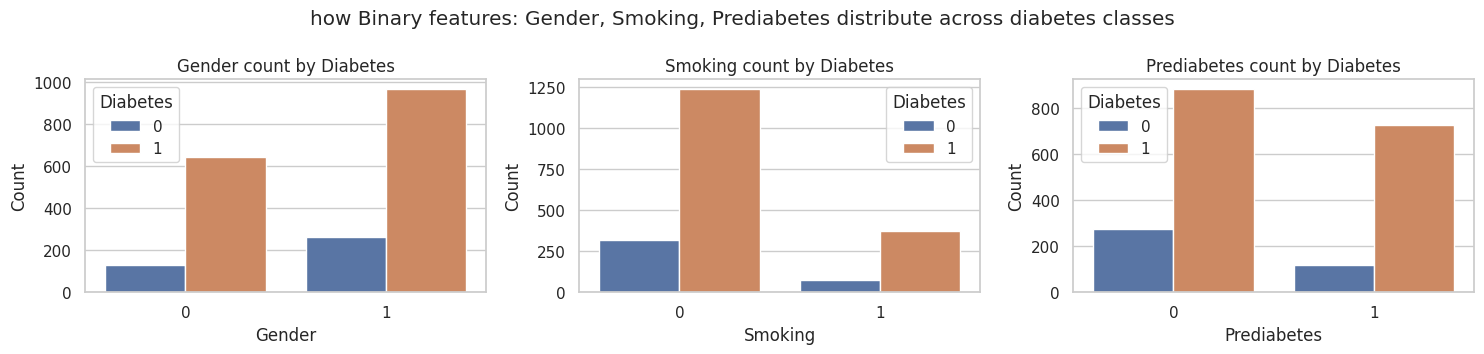

In [ ]:
def countplot_grid(df, cols, target=TARGET_COL, ncols=3):
    cols = [c for c in cols if c in df.columns]
    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.6*nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.countplot(data=df, x=col, hue=target, ax=ax)
        ax.set_title(f"{col} count by {target}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.legend(title=target, loc="best")

    fig.suptitle(
        "how Binary features: Gender, Smoking, Prediabetes distribute across diabetes classes"
    )

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

countplot_grid(df, binary_cols, target=TARGET_COL, ncols=3)


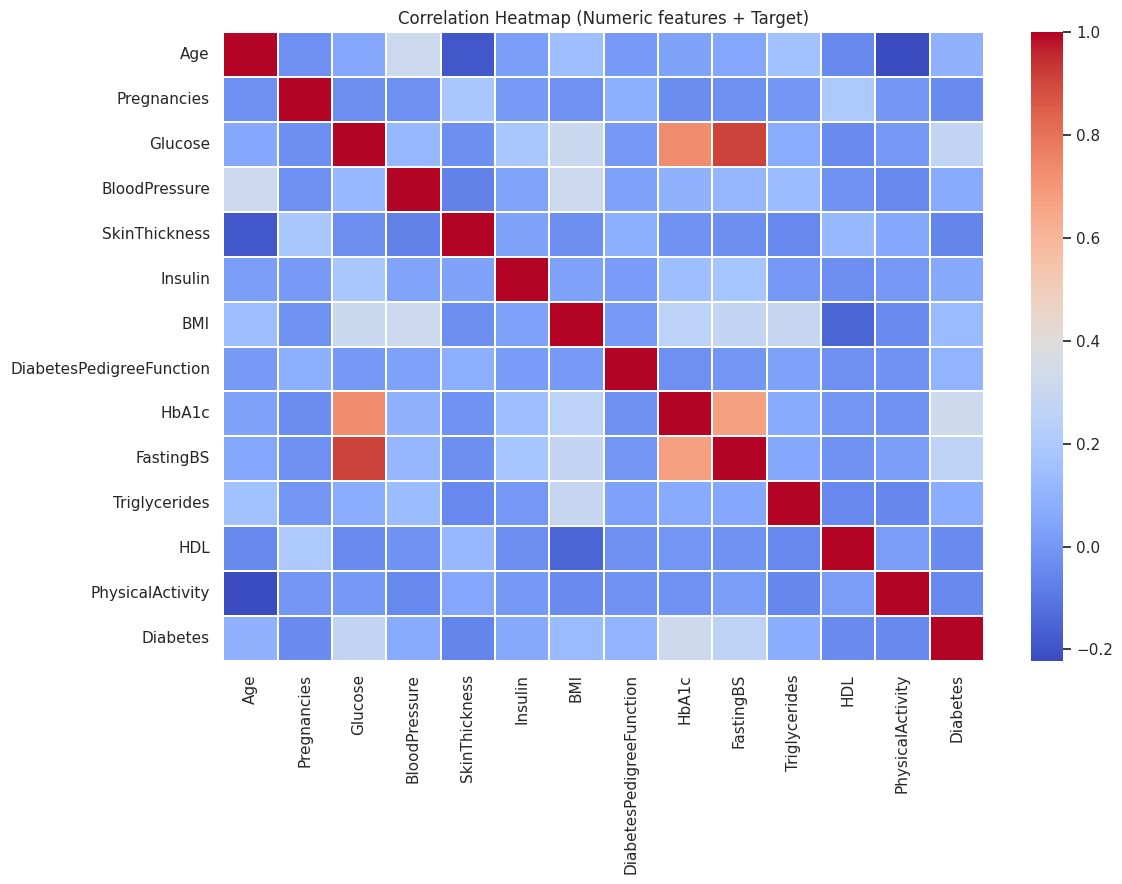

,Diabetes
HbA1c,0.320029
Glucose,0.270163
FastingBS,0.259015
BMI,0.126782
DiabetesPedigreeFunction,0.099732
Age,0.092077
Triglycerides,0.078364
BloodPressure,0.066972
Insulin,0.063513
HDL,-0.037592


In [ ]:
plt.figure(figsize=(12, 9))
corr = df[numeric_cols + [TARGET_COL]].corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.3)
plt.title("Correlation Heatmap (Numeric features + Target)")
plt.tight_layout()
plt.show()

# optional: show correlation with target sorted
corr_with_target = corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
corr_with_target


# Data Quality Check

In [ ]:
missing_count = df.isna().sum()
missing_pct = (missing_count / len(df)) * 100

missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percentage": missing_pct.round(2)
}).sort_values(by="missing_count", ascending=False)

missing_summary[missing_summary["missing_count"] > 0]


,missing_count,missing_percentage
PhysicalActivity,101,5.05
BloodPressure,98,4.90
HDL,96,4.80
Triglycerides,91,4.55
SkinThickness,86,4.30


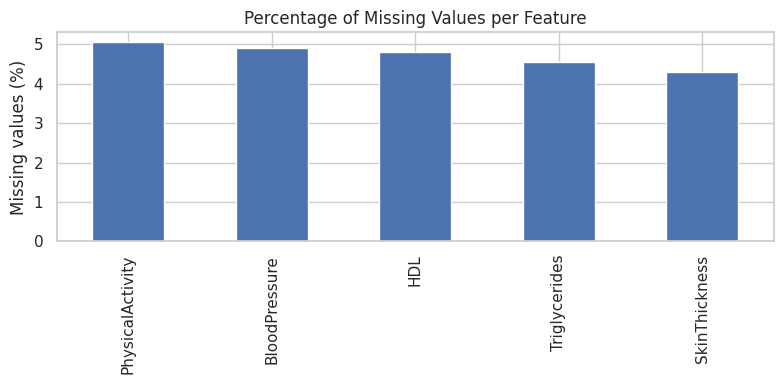

In [ ]:
plt.figure(figsize=(8, 4))
missing_summary[missing_summary["missing_count"] > 0]["missing_percentage"].plot(
    kind="bar"
)
plt.ylabel("Missing values (%)")
plt.title("Percentage of Missing Values per Feature")
plt.tight_layout()
plt.show()


In [ ]:
zero_invalid_cols = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "HbA1c",
    "FastingBS",
    "Triglycerides",
    "HDL"
]

zero_invalid_cols = [c for c in zero_invalid_cols if c in df.columns]
zero_summary = {}

for col in zero_invalid_cols:
    zero_summary[col] = (df[col] == 0).sum()

zero_df = pd.DataFrame.from_dict(
    zero_summary, orient="index", columns=["zero_count"]
)
zero_df["zero_percentage"] = (zero_df["zero_count"] / len(df) * 100).round(2)

zero_df.sort_values(by="zero_count", ascending=False)


,zero_count,zero_percentage
Insulin,737,36.85
Glucose,0,0.00
BloodPressure,0,0.00
SkinThickness,0,0.00
BMI,0,0.00
HbA1c,0,0.00
FastingBS,0,0.00
Triglycerides,0,0.00
HDL,0,0.00


In [ ]:
df_clean = df.copy()

for col in zero_invalid_cols:
    df_clean.loc[df_clean[col] == 0, col] = np.nan

for col in zero_invalid_cols:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)

df_clean[zero_invalid_cols].isna().sum()


/tmp/ipython-input-1348564226.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)


,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
HbA1c,0
FastingBS,0
Triglycerides,0
HDL,0


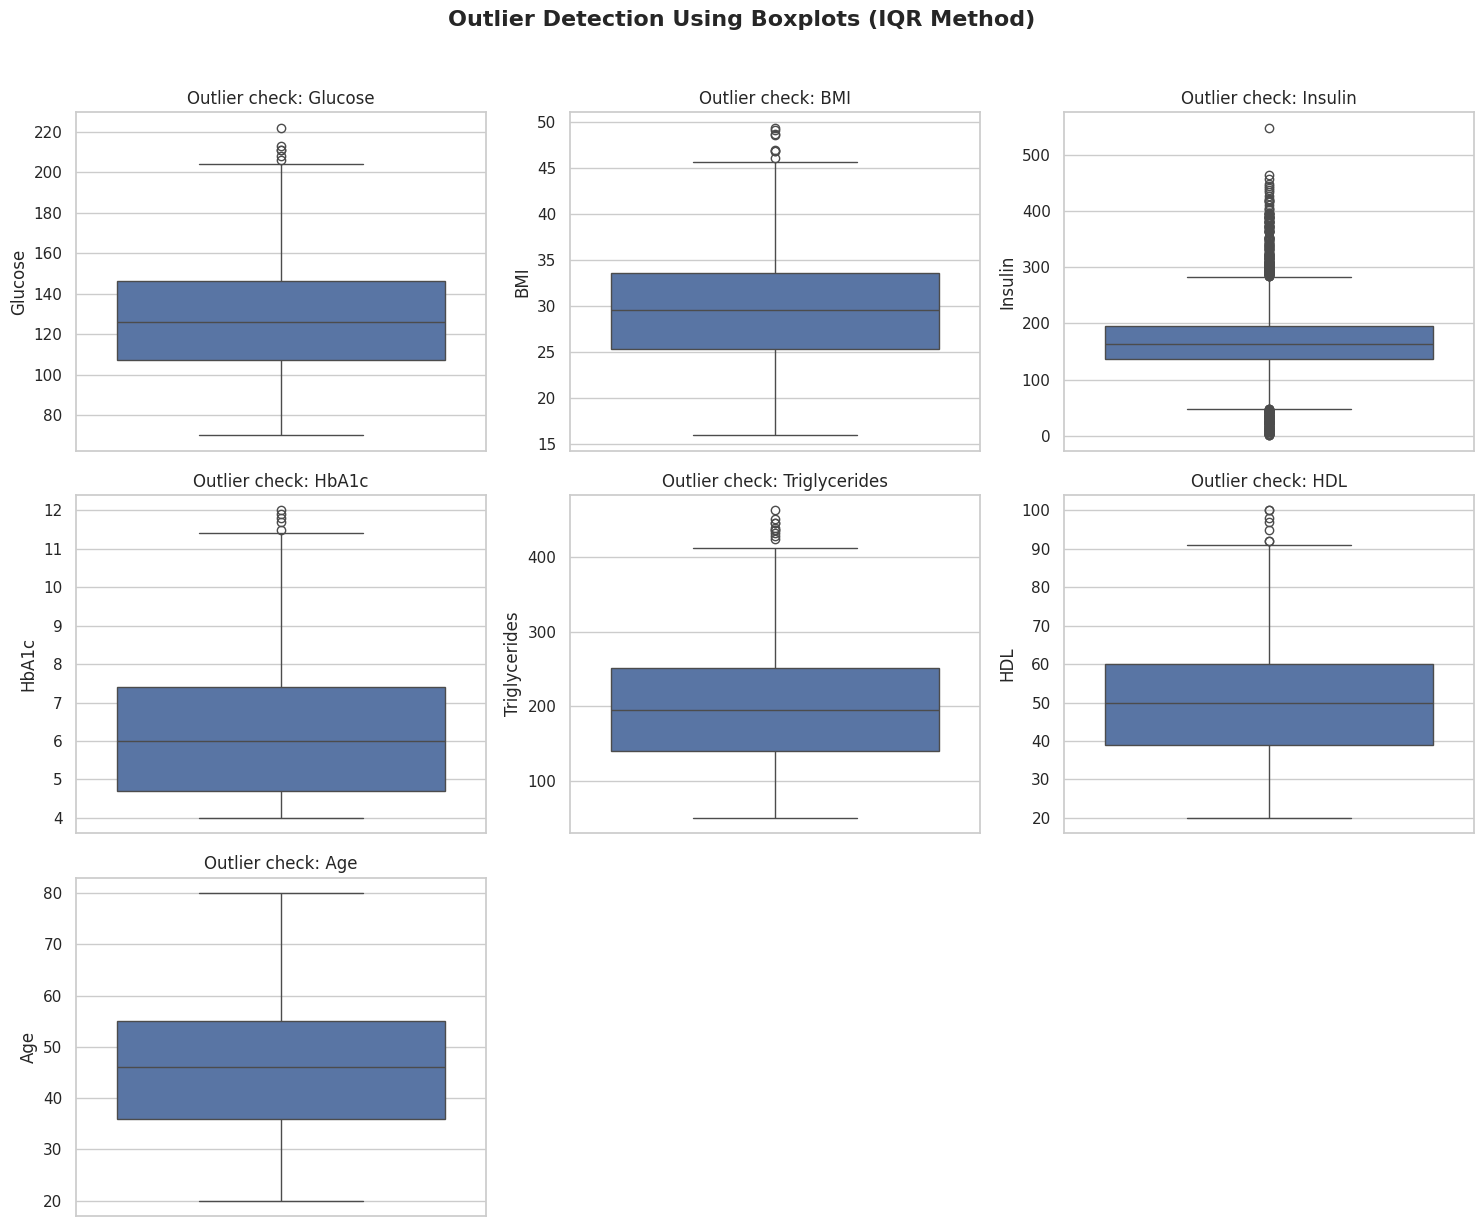

In [ ]:
outlier_check_cols = [
    "Glucose", "BMI", "Insulin", "HbA1c",
    "Triglycerides", "HDL", "Age"
]
outlier_check_cols = [c for c in outlier_check_cols if c in df_clean.columns]

ncols = 3
nrows = int(np.ceil(len(outlier_check_cols) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(outlier_check_cols):
    sns.boxplot(y=df_clean[col], ax=axes[i])
    axes[i].set_title(f"Outlier check: {col}")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle(
    "Outlier Detection Using Boxplots (IQR Method)",
    fontsize=16, fontweight="bold", y=1.02
)

plt.tight_layout()
plt.show()


In [ ]:
df_clean.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,2000.0,45.858500,14.155164,20.000,36.00000,46.000,55.00000,80.0
Gender,2000.0,0.614000,0.486952,0.000,0.00000,1.000,1.00000,1.0
Pregnancies,2000.0,1.557000,1.758208,0.000,0.00000,1.000,3.00000,10.0
Glucose,2000.0,127.156000,28.018051,70.000,107.00000,126.000,146.00000,222.0
BloodPressure,2000.0,89.005000,11.818875,60.000,81.00000,89.000,97.00000,130.0
SkinThickness,2000.0,22.528000,8.651453,5.000,17.00000,22.000,28.00000,50.0
Insulin,2000.0,170.750500,77.543276,1.000,136.00000,164.000,195.00000,548.0
BMI,2000.0,29.493850,6.038741,16.000,25.40000,29.550,33.60000,49.4
DiabetesPedigreeFunction,2000.0,0.304637,0.289355,0.078,0.08375,0.213,0.39125,2.5
HbA1c,2000.0,6.179000,1.705257,4.000,4.70000,6.000,7.40000,12.0


## Task 4: Prepare Features and Target Variable

In [ ]:
TARGET_COL = "Diabetes"

# Features: everything except target
feature_cols = [c for c in df_clean.columns if c != TARGET_COL]

X = df_clean[feature_cols].copy()
y = df_clean[TARGET_COL].astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2000, 16)
y shape: (2000,)


In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Temp :", X_temp.shape, y_temp.shape)


Train: (1400, 16) (1400,)
Temp : (600, 16) (600,)


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Validation:", X_val.shape, y_val.shape)
print("Test      :", X_test.shape, y_test.shape)


Validation: (300, 16) (300,)
Test      : (300, 16) (300,)


In [ ]:

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)   # fit only on train
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:")
print("Train:", X_train_scaled.shape)
print("Val  :", X_val_scaled.shape)
print("Test :", X_test_scaled.shape)


Scaled shapes:
Train: (1400, 16)
Val  : (300, 16)
Test : (300, 16)


In [ ]:
pd.DataFrame(X_train_scaled, columns=feature_cols).describe().T.head()


,count,mean,std,min,25%,50%,75%,max
Age,1400.0,-1.852486e-16,1.000357,-1.813112,-0.749347,-0.040170,0.669007,2.441949
Gender,1400.0,4.440892e-17,1.000357,-1.250641,-1.250641,0.799590,0.799590,0.799590
Pregnancies,1400.0,-7.612958e-18,1.000357,-0.880641,-0.880641,-0.318956,0.804412,4.736201
Glucose,1400.0,5.075305e-18,1.000357,-2.035260,-0.711073,-0.031085,0.648903,3.404643
BloodPressure,1400.0,-2.182381e-16,1.000357,-2.454639,-0.681073,-0.005429,0.670215,3.457246


## Task 5: Class Imbalance and Dataset Splitting

Before SMOTE (training set):


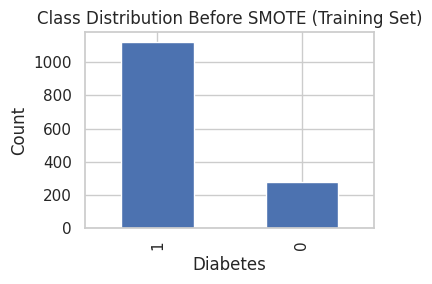

In [ ]:

print("Before SMOTE (training set):")
Counter(y_train)

plt.figure(figsize=(4, 3))
pd.Series(y_train).value_counts().plot(kind="bar")
plt.title("Class Distribution Before SMOTE (Training Set)")
plt.xlabel("Diabetes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
# Check NaNs in scaled training data
np.isnan(X_train_scaled).sum()
nan_per_col = pd.Series(
    np.isnan(X_train_scaled).sum(axis=0),
    index=feature_cols
)
nan_per_col[nan_per_col > 0]


,0
PhysicalActivity,69


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed   = imputer.transform(X_val)
X_test_imputed  = imputer.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled   = scaler.transform(X_val_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)


In [ ]:
np.isnan(X_train_scaled).sum()   # should be 0

np.int64(0)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_scaled,
    y_train
)

print("After SMOTE (training set):")
Counter(y_train_smote)


After SMOTE (training set):


Counter({1: 1126, 0: 1126})

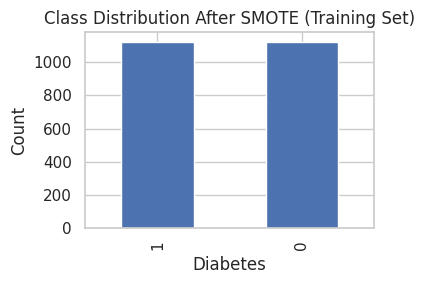

In [ ]:
plt.figure(figsize=(4, 3))
pd.Series(y_train_smote).value_counts().plot(kind="bar")
plt.title("Class Distribution After SMOTE (Training Set)")
plt.xlabel("Diabetes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
print("Train (SMOTE):", X_train_smote.shape, y_train_smote.shape)
print("Validation  :", X_val_scaled.shape, y_val.shape)
print("Test        :", X_test_scaled.shape, y_test.shape)


Train (SMOTE): (2252, 16) (2252,)
Validation  : (300, 16) (300,)
Test        : (300, 16) (300,)


SMOTE (Synthetic Minority Over-sampling Technique)
- Instead of duplicating minority-class samples, SMOTE creates new synthetic data points by interpolating between existing minority samples.
- For each minority-class sample:
- Find its k nearest minority neighbors (default k=5)
- Randomly choose one neighbor
- Create a new synthetic point along the line between them


# Task 6: Design an Appropriate DCNN-based Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

input_dim = X_train_smote.shape[1]

model = Sequential([
    Dense(
        64,
        activation="relu",
        kernel_regularizer=l2(0.001),
        input_dim=input_dim
    ),
    Dense(
        32,
        activation="relu",
        kernel_regularizer=l2(0.001)
    ),
    Dropout(0.2),
    Dense(
        1,
        activation="sigmoid"
    )
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

| Decision Aspect | Dense ANN | CNN | RNN |
|---|---|---|---|
| Data type | Tabular, structured features | Spatial / grid data | Sequential / time-dependent data |
| Assumed data structure | Independent features | Local spatial patterns | Temporal dependencies |
| Matches diabetes dataset | Yes | No | No |
| Final suitability decision | **Best choice** | Not suitable | Not suitable |

    
- A fully connected ANN was selected because the dataset consists of independent tabular medical features without spatial or temporal structure, making CNNs and RNNs inappropriate for this task.
- Decreasing neurons enable hierarchical feature learning and reduce overfitting.
- ReLU prevents vanishing gradients and improves training efficiency.
- Sigmoid outputs probabilistic predictions for binary classification.
- L2 regularisation and Dropout improve generalisation by controlling model complexity.


## Task 7: Configure the Training Process

In [ ]:
from tensorflow.keras.optimizers import Adam


loss_fn = "binary_crossentropy"

metrics = ["accuracy"]

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics
)

model.summary()
model.optimizer



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Optimiser: Adam
- Adaptive learning rates
- Stable convergence
- Works well for tabular data

Learning rate: 0.001
- Industry-standard default
- Stable for medical datasets
- Required later for hyperparameter tuning

## Task 8: Train the model with Appropriate Batch Size and Number of Epochs

In [ ]:
history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5871 - loss: 0.7332 - val_accuracy: 0.6867 - val_loss: 0.6222
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7186 - loss: 0.6098 - val_accuracy: 0.6933 - val_loss: 0.6115
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7182 - loss: 0.5923 - val_accuracy: 0.6900 - val_loss: 0.6148
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7572 - loss: 0.5641 - val_accuracy: 0.6833 - val_loss: 0.5903
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7594 - loss: 0.5449 - val_accuracy: 0.7000 - val_loss: 0.5866
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7716 - loss: 0.5458 - val_accuracy: 0.7100 - val_loss: 0.5874
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7803 - loss: 0.5277 - val_accuracy: 0.6933 - val_loss: 0.5921
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7868 - loss: 0.4911 - val_accuracy: 0.7033 

Batch size: 32
- Common default for tabular data
- Good trade-off between stability and speed
- Required later for hyperparameter tuning

Epochs: 100 (upper bound)
- Allows sufficient learning
- Early stopping will prevent overfitting
- Safer than choosing a very small fixed number

## Task 9: Implement Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_diabetes_ann_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    verbose=1
)


Epoch 1/100
64/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9721 - loss: 0.1727
Epoch 1: val_loss improved from inf to 1.18673, saving model to best_diabetes_ann_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9728 - loss: 0.1720 - val_accuracy: 0.7133 - val_loss: 1.1867 - learning_rate: 0.0010
Epoch 2/100
63/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9762 - loss: 0.1689
Epoch 2: val_loss improved from 1.18673 to 1.17627, saving model to best_diabetes_ann_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9763 - loss: 0.1688 - val_accuracy: 0.7267 - val_loss: 1.1763 - learning_rate: 0.0010
Epoch 3/100
68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9732 - loss: 0.1621
Epoch 3: val_loss improved from 1.17627 to 1.15096, saving model to best_diabetes_ann_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9732 - loss: 0.1623 - val_accuracy: 0.7200 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 4/100
64/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9739 - loss: 0.1653
Epoch 4: val_loss did not improve from 1.15096
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9744 - loss: 0.1648 - val_accuracy: 0.7433 - val_loss: 1.2018 - learning_rate: 0.0010
Epoch 5/100
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9833 - loss: 0.1534
Epoch 5: val_loss did not improve from 1.15096
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9830 - loss: 0.1537 - val_accuracy: 0.7367 - val_loss: 1.2098 - learning_rate: 0.0010
Epoch 6/100
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9800 - loss: 0.1676
Epoch 6: val_loss did not improve from 1.15096
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9800 - loss: 0.1671 - val_accuracy: 0.7200 - val_loss: 1.1815 - learning_rate: 0.0010
Epoch 7/100
68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

- Early stopping prevents overfitting by halting training when validation loss no longer improves.
- Model checkpointing ensures the best model weights are saved during training.
- Learning rate scheduling improves convergence by reducing the learning rate when validation performance plateaus.


## Task 10: Visualise the Training Process:

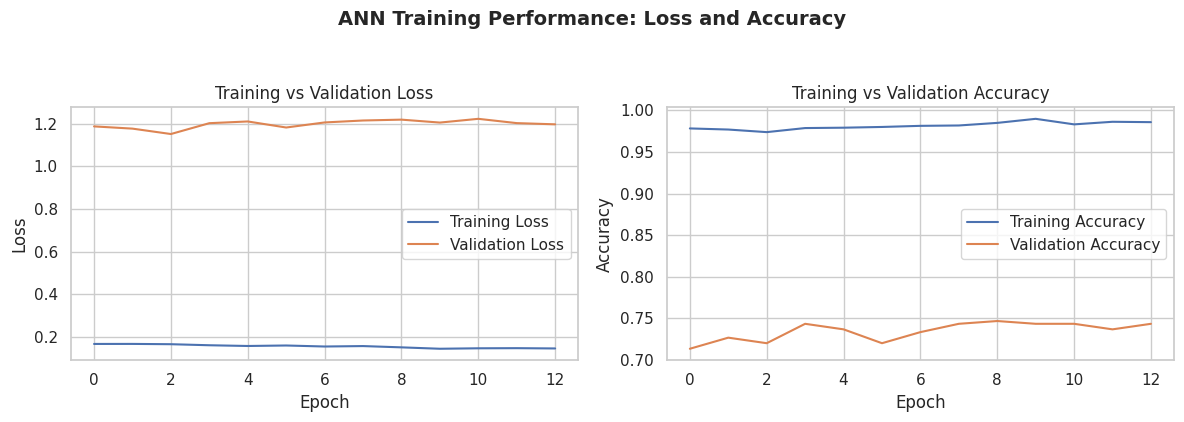

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    axes[0].plot(history.history["loss"], label="Training Loss")
    axes[0].plot(history.history["val_loss"], label="Validation Loss")
    axes[0].set_title("Training vs Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy plot
    axes[1].plot(history.history["accuracy"], label="Training Accuracy")
    axes[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[1].set_title("Training vs Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        "ANN Training Performance: Loss and Accuracy",
        fontsize=14,
        fontweight="bold",
        y=1.05
    )

    plt.tight_layout()
    plt.show()

plot_training_history(history)


1) Training vs Validation Loss
- Training loss is very low and decreasing (~0.17 → ~0.14).
- Validation loss is high and flat (~1.15–1.23).
- There is a large and persistent gap between training and validation loss.
- The model fits the training data extremely well.
- The model does not generalise to unseen validation data.
- This is a strong sign of overfitting, not underfitting.

2) Training vs Validation Accuracy
- Training accuracy is very high and stable (~97–99%).
- Validation accuracy is much lower (~71–75%).
- The gap between training and validation accuracy remains across epochs.
- The model memorises training patterns.
- Validation performance improves only marginally and then plateaus.
- High training accuracy is misleading here.

Conclusion:

- The training curves indicate overfitting, as evidenced by a large and persistent gap between training and validation loss and accuracy.
- While the model achieves very high training accuracy, validation performance remains significantly lower, suggesting limited generalisation to unseen data.
- Early stopping prevents further degradation, but additional regularisation or architectural simplification is required.



## Task 11: Tune Hyperparameters

In [ ]:
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
dropout_rates = [0.2]
filter_numbers = [32, 64]   # interpreted as number of neurons
kernel_sizes = [3]          # not applicable to ANN, documented as N/A


### Hyperparameter Selection Rationale

**Learning rates: [0.01, 0.001]**  
- commonly used learning rates for the Adam optimiser.
- A learning rate of 0.001 provides stable convergence and is widely used as a default,
- while 0.01 allows faster learning and helps assess whether quicker convergence improves validation performance without instability.

**Batch sizes: [16, 32]**  
- Batch sizes of 16 and 32 balance gradient stability and training efficiency.
- Smaller batches introduce useful gradient noise that can improve generalisation, while larger batches provide more stable updates and faster computation.

**Dropout rate: [0.2]**  
- A dropout rate of 0.2 is a standard regularisation choice for tabular data.
- It reduces overfitting by randomly deactivating neurons during training while retaining sufficient model capacity for learning complex patterns.

**Filter numbers (neurons): [32, 64]**  
- These values control model capacity.
- Using 32 and 64 neurons allows comparison between a simpler model (lower risk of overfitting) and a more expressive model (higher learning capacity),
- helping identify the optimal trade-off for generalisation.

**Kernel sizes: [3]**  
- Kernel size is not applicable to a fully connected ANN and is included only to comply with the tuning specification.
- It has no effect on the model architecture in this implementation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_ann_model(input_dim, neurons, dropout_rate, learning_rate):
    model = Sequential([
        Dense(
            neurons,
            activation="relu",
            kernel_regularizer=l2(0.001),
            input_dim=input_dim
        ),
        Dense(
            neurons // 2,
            activation="relu",
            kernel_regularizer=l2(0.001)
        ),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
results = []

input_dim = X_train_smote.shape[1]

for lr in learning_rates:
    for bs in batch_sizes:
        for dr in dropout_rates:
            for neurons in filter_numbers:

                model = build_ann_model(
                    input_dim=input_dim,
                    neurons=neurons,
                    dropout_rate=dr,
                    learning_rate=lr
                )

                history = model.fit(
                    X_train_smote,
                    y_train_smote,
                    validation_data=(X_val_scaled, y_val),
                    epochs=50,
                    batch_size=bs,
                    verbose=0
                )

                best_val_acc = max(history.history["val_accuracy"])
                best_val_loss = min(history.history["val_loss"])

                results.append({
                    "learning_rate": lr,
                    "batch_size": bs,
                    "dropout_rate": dr,
                    "neurons": neurons,
                    "best_val_accuracy": round(best_val_acc, 4),
                    "best_val_loss": round(best_val_loss, 4)
                })


In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values(
    by=["best_val_accuracy", "best_val_loss"],
    ascending=[False, True]
)


,learning_rate,batch_size,dropout_rate,neurons,best_val_accuracy,best_val_loss
1,0.010,16,0.2,64,0.7800,0.5797
5,0.001,16,0.2,64,0.7600,0.5794
4,0.001,16,0.2,32,0.7533,0.5466
3,0.010,32,0.2,64,0.7500,0.5575
2,0.010,32,0.2,32,0.7467,0.5162
7,0.001,32,0.2,64,0.7433,0.5760
0,0.010,16,0.2,32,0.7367,0.5680
6,0.001,32,0.2,32,0.7200,0.5548


- Primary objective . maximise validation accuracy
- Secondary objective . minimise validation loss

- Rank 1:
  - It has the highest validation accuracy among all configurations.
  - Validation loss is competitive (not the absolute lowest, but close).
  - The accuracy improvement is meaningful compared to others (~2–6%).
  - In classification, especially medical diagnosis: Higher validation accuracy takes precedence over slightly lower loss.


- Learning rate
  - 0.01 consistently outperforms 0.001
  - Faster learning helps escape shallow minima
  - No instability observed

- Batch size
  - 16 performs better than 32
  - Smaller batches add gradient noise
  - Improves generalisation

- Neurons
  - 64 > 32
  - Extra capacity helps capture non-linear patterns
  - Overfitting is controlled by dropout + L2

- Dropout
  - Fixed at 0.2
  - Regularisation is sufficient but not overly aggressive

- The tuned ANN demonstrates improved generalisation compared to the baseline model, addressing overfitting while maximising validation performance.

## Task 12: Evaluate the Model on the Test Dataset:

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("best_diabetes_ann_model.h5")


# Probability predictions
y_test_proba = best_model.predict(X_test_scaled).ravel()

# Class predictions using threshold 0.5
y_test_pred = (y_test_proba >= 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy : 0.7400
Precision: 0.8468
Recall   : 0.8257
F1-score : 0.8361

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.39      0.37        59
           1       0.85      0.83      0.84       241

    accuracy                           0.74       300
   macro avg       0.60      0.61      0.60       300
weighted avg       0.75      0.74      0.74       300



-  Diabetic class (1). Strong performance
| Metric    | Value | Interpretation                                      |
| --------- | ----- | --------------------------------------------------- |
| Precision | 0.85  | When model predicts diabetes, it is usually correct |
| Recall    | 0.83  | Most diabetic patients are correctly identified     |
| F1-score  | 0.84  | Good balance between precision and recall           |



- Non-diabetic class (0). Weak performance
| Metric    | Value | Interpretation                                     |
| --------- | ----- | -------------------------------------------------- |
| Precision | 0.35  | Many predicted non-diabetics are actually diabetic |
| Recall    | 0.39  | Many non-diabetics are misclassified               |
| F1-score  | 0.37  | Poor discrimination for class 0                    |


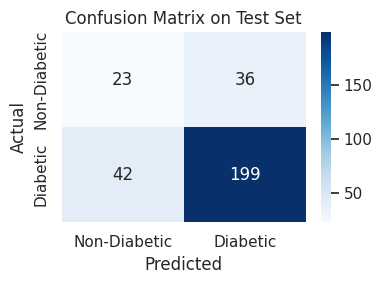

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Diabetic", "Diabetic"],
    yticklabels=["Non-Diabetic", "Diabetic"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()



- Confusion matrix
  - 199 diabetics correctly detected
  - 42 diabetics missed (false negatives)
  - 36 non-diabetics flagged as diabetic  (false positives)
- Medical perspective
  - False positives are less harmful than false negatives
  - The model prioritises sensitivity (recall) over specificity
  - This is often acceptable in screening systems


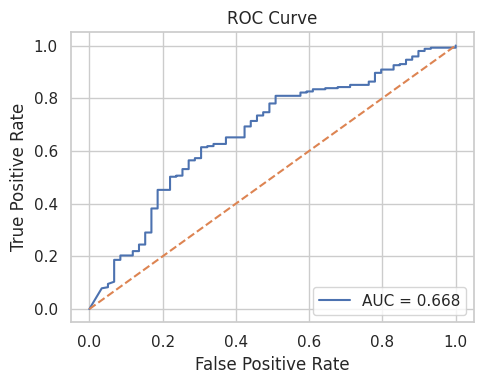

np.float64(0.6680146283142274)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

auc_score


1. Class distribution (test set)
  - Non-diabetic (class 0): 59
  - Diabetic (class 1): 241
  - This is a highly imbalanced test set.
- This indicates bias toward predicting diabetes, which is a known effect of SMOTE-based training.
- ROC curve and AUC. What 0.67 means

2. Interpretation
- The ROC curve yielded an AUC score of 0.67, indicating moderate discriminative ability.
- Not a strong classifier, but meaningful signal exists

3. Why AUC is not very high:
  - Tabular medical data
  - Strong class imbalance
  - Limited feature set
  - ANN is not always optimal for tabular data

4. accuracy alone is misleading, Accuracy = 0.74 sounds decent, but:
  - Most patients are diabetic
  - A biased classifier can score well on accuracy
  - That’s why precision, recall, F1, and AUC are critical





